In [1]:
# Data manipulation
import pandas as pd 
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Stats
import scipy.stats as stats

# Other
import os
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

### Сведения о данных

Данные о 90189 игроках, которые установили приложение с момента запуска AB-теста.

Датасет содержит следующие переменные: 
* userid - уникальный номер, идентифицирующий каждого игрока;
* version - попал игрок в контрольную (gate_30) или в тестовую группы (gate_40);
* sum_gamerounds - количество сыгранных раундов в течение первой недели после установки;
* retention_1  - сыграл ли пользователь спустя 1 день после установки?
* retention_7 - сыграл ли пользователь спустя 7 дней после установки?

Во время установки игры пользователь случайным образом помещается в ту или иную группы.

### Разведочный анализ данных

In [4]:
df = pd.read_csv(os.path.join(os.getcwd(), "cookie_cats.csv"))
df.head()

userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True

In [5]:
print(f'Датасет содержит {df.shape[0]} строк и {df.shape[1]} колонок')
print('')
print('')
print('--------------------------------------')
if sum([i for i in df.isna().sum()]) > 0:
    print(f'Датасет содержит {sum([i for i in df.isna().sum()])} NaN значений')
else:
    print(f'Датасет не содержит NaN значений')
print('')
print('')
print('--------------------------------------')
if len(df.select_dtypes("object").columns) > 0:
    print("Переменные типа Object:", "\n", "Количество переменных:", 
          len(df.select_dtypes("object").columns), "\n", 
          df.select_dtypes("object").columns.tolist(), "\n")
    
if len(df.select_dtypes("integer").columns) > 0:
    print("Переменные типа Integer:", "\n", "Количество переменных:", 
          len(df.select_dtypes("integer").columns), "\n", 
          df.select_dtypes("integer").columns.tolist(), "\n")
    
if len(df.select_dtypes("float").columns) > 0:
    print("Переменные типа Float:", "\n", "Количество переменных:", 
          len(df.select_dtypes("float").columns), "\n", 
          df.select_dtypes("float").columns.tolist(), "\n")
    
if len(df.select_dtypes("bool").columns) > 0:
    print("Переменные типа Bool:", "\n", "Количество переменных:", 
          len(df.select_dtypes("bool").columns), "\n", 
          df.select_dtypes("bool").columns.tolist(), "\n")

Датасет содержит 90189 строк и 5 колонок


--------------------------------------
Датасет не содержит NaN значений


--------------------------------------
Переменные типа Object: 
 Количество переменных: 1 
 ['version'] 

Переменные типа Integer: 
 Количество переменных: 2 
 ['userid', 'sum_gamerounds'] 

Переменные типа Bool: 
 Количество переменных: 2 
 ['retention_1', 'retention_7'] 



___________
```
Все ли пользователи уникальны или есть повторения?
```

In [6]:
if df.userid.nunique() == df.shape[0]:
    print('Все пользователи уникальны')
else:
    print('Некоторые пользователи попали в выборку неоднократно')

Все пользователи уникальны


```
Теперь посмотрим, как распределена переменная sum_gamerounds
```

In [7]:
df.describe([0.01, 0.05, 0.25, 0.75, 0.95, 0.99])[["sum_gamerounds"]].T

count       mean         std  min   1%   5%  25%   50%  \
sum_gamerounds  90189.0  51.872457  195.050858  0.0  0.0  1.0  5.0  16.0   

                 75%    95%    99%      max  
sum_gamerounds  51.0  221.0  493.0  49854.0

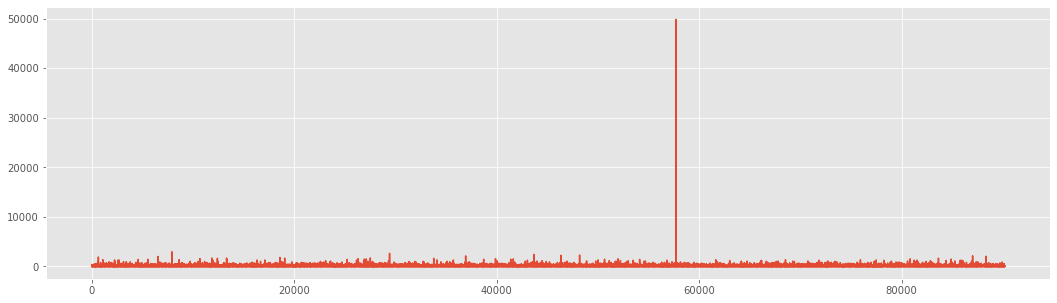

In [8]:
df['sum_gamerounds'].plot(figsize=(18,5));

```
Сразу слеудует обратить внимание, что при среднем ~ 51.9 и медиане ~ 16, максимальное значение - 49854
Исключим это экстремальное значение. Вероятно, этот userid принадлежит админу
```

In [9]:
df = df.query('sum_gamerounds < 49854')
df.describe([0.01, 0.05, 0.25, 0.75, 0.95, 0.99])[["sum_gamerounds"]].T

count       mean         std  min   1%   5%  25%   50%  \
sum_gamerounds  90188.0  51.320253  102.682719  0.0  0.0  1.0  5.0  16.0   

                 75%    95%    99%     max  
sum_gamerounds  51.0  221.0  493.0  2961.0

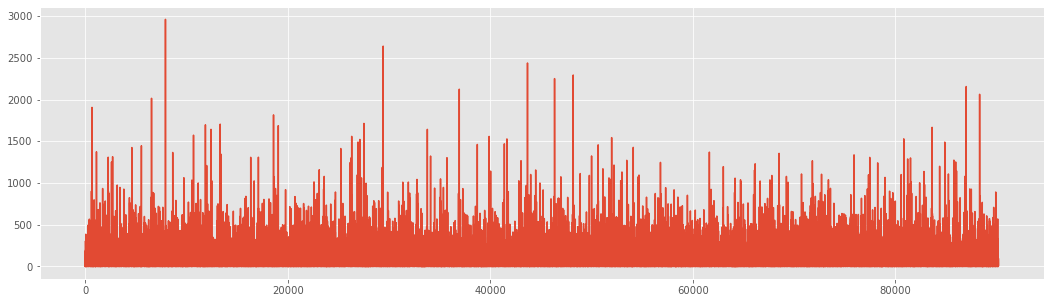

In [10]:
df['sum_gamerounds'].plot(figsize=(18,5));

```
Выведем описательные статистики по группам (версиям)
```

In [11]:
df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median       mean         std   max
version                                            
gate_30  44699      17  51.342111  102.057598  2961
gate_40  45489      16  51.298776  103.294416  2640

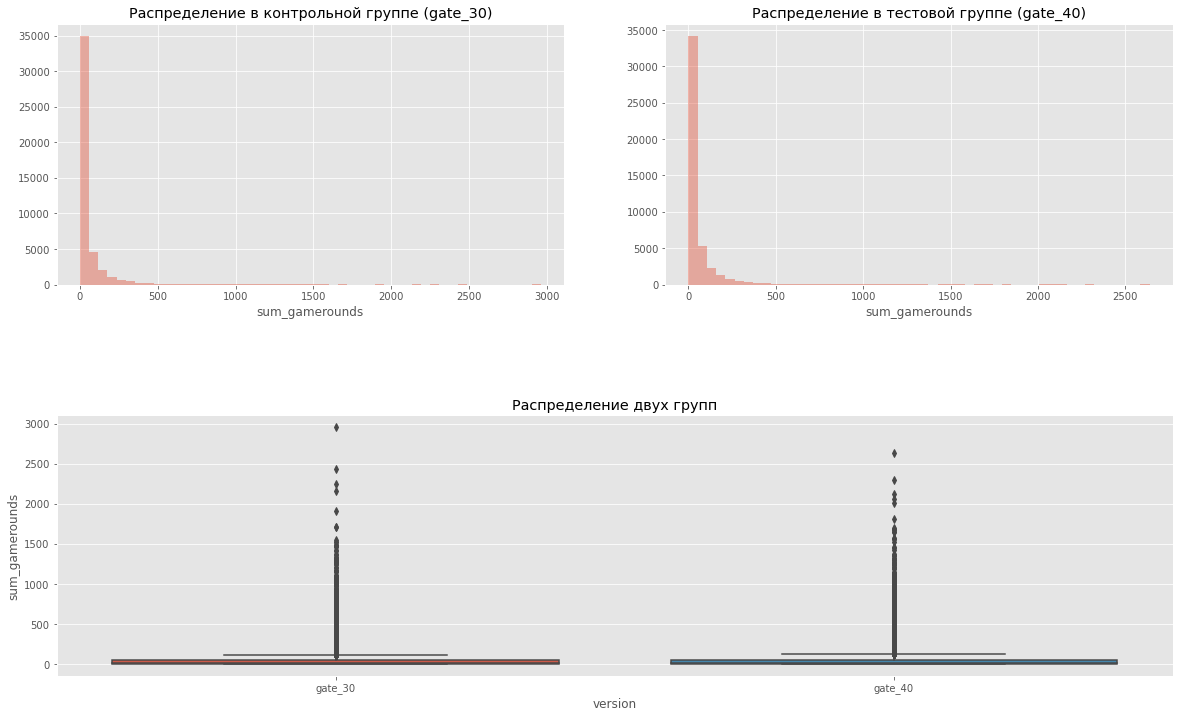

In [12]:
fig = plt.figure(figsize = (20,12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)
fig.subplots_adjust(hspace=.5)

sns.distplot(df.query('version=="gate_30"')['sum_gamerounds'], ax=ax1, kde=False)
sns.distplot(df.query('version=="gate_40"')['sum_gamerounds'], ax=ax2, kde=False)
sns.boxplot(x = df.version, y = df.sum_gamerounds, ax=ax3)

ax1.set_title('Распределение в контрольной группе (gate_30)')
ax2.set_title('Распределение в тестовой группе (gate_40)')
ax3.set_title('Распределение двух групп');

```
Обратим внимание, большая часть пользователей находится в диапазоне от 0 до 100.
```

In [13]:
df.query('sum_gamerounds==0')['userid'].count()

3994

**3994** пользователя установив игру, ни разу в нее не играли.

Причинами могут служить:
* Отсутствие свободного времени;
* Возможно, люди установили себе игру на будущее, а в настоящий момент играют во что-то другое;
* Кому-то не понравилось само по себе приложение (например, интерфейс);
* и др.

______

```
А каков был retention?
```

In [14]:
ret_df = df[['retention_1', 'retention_7']].apply(pd.Series.value_counts)

In [15]:
print(f'Retention_1 ratio = {ret_df.loc[True, "retention_1"]/ret_df["retention_1"].sum()}')
print(f'Retention_7 ratio = {ret_df.loc[True, "retention_7"]/ret_df["retention_7"].sum()}')

Retention_1 ratio = 0.4452144409455803
Retention_7 ratio = 0.1860557945624695


In [16]:
df.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median       mean         std   max
version retention_1                                            
gate_30 False        24665       6  16.359092   36.528426  1072
        True         20034      48  94.411700  135.037697  2961
gate_40 False        25370       6  16.340402   35.925756  1241
        True         20119      49  95.381182  137.887256  2640

In [17]:
df.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version retention_7                                             
gate_30 False        36198      11   25.796508   43.316158   981
        True          8501     105  160.117516  179.358560  2961
gate_40 False        37210      11   25.856356   44.406112  2640
        True          8279     111  165.649837  183.792499  2294

In [18]:
df['retention'] = np.where((df.retention_1 == True) & (df.retention_7 == True), 'True', 'False')

In [19]:
df.groupby(["version", "retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version retention                                             
gate_30 False      38023      12   28.070273   48.017452  1072
        True        6676     127  183.886309  189.626390  2961
gate_40 False      38983      12   28.103353   48.927850  2640
        True        6506     133  190.282355  194.220077  2294

**Retention_1:**
* 44.5% пользователей играли на следующий день после установки приложения

**Retention_7:**
* 18.6% пользователей играли через неделю после установки приложения

**Retention**:
* 14.6% пользователей играли и на следующий день, и через неделю после установки приложения

```
Контрольная и тестовая группы кажутся похожими, глядя на описательную статистику.
Применим статистические тесты, чтобы проверить, есть ли статистически значимые различия или нет.
```

### A/B-тестирование

```
Засплитим датасет на 2 группы - gate_30 (A) и gate_40 (B)
```

In [20]:
groupA = df.query('version=="gate_30"')['sum_gamerounds']
groupB = df.query('version=="gate_40"')['sum_gamerounds']

```
Проверим эти группы на нормальность распределения тестом Шапиро-Уилка
```

In [21]:
if stats.shapiro(groupA)[1] > 0.05:
    print('Распределение признака sum_gamerounds в группе A соответствует нормальному')
else:
    print('Распределение признака sum_gamerounds в группе A не соответствует нормальному')
    
if stats.shapiro(groupB)[1] > 0.05:
    print('Распределение признака sum_gamerounds в группе B соответствует нормальному')
else:
    print('Распределение признака sum_gamerounds в группе B не соответствует нормальному')

Распределение признака sum_gamerounds в группе A не соответствует нормальному
Распределение признака sum_gamerounds в группе B не соответствует нормальному


```
В связи с тем, что признак sum_gamerounds в обеих выборках не соответствует нормальному распределению, а также несмотря на то, что ранее было исключено эктремальное значение sum_gamerounds = 49854, выборки имеют большое количество выбросов, применим непараметрический тест -  U-критерий Манна-Уитни
```

Нулевая гипотеза $H_0$: Группы не имеют статистически значимых различий (т.е. количество сыгранных раундов не зависит от того, в какую группу попадал пользователь)

Альтернативная гипотеза $H_1$: Группы имеют статистически значимые различия (т.е. количество сыгранных раундов зависит от того, в какую группу попадал пользователь)

In [22]:
if stats.mannwhitneyu(groupA, groupB)[1] < 0.05:
    print(f'Нет достаточных оснований принять нулевую гипотезу, т.к. p-value = {stats.mannwhitneyu(groupA, groupB)[1]}, следовательно принимаем альтернативную гипотезу - группы имеют статистически значимые различия')
else:
    print(f'Нет достаточных оснований отклонить нулевую гипотезу, т.к. p-value = {stats.mannwhitneyu(groupA, groupB)[1]}, следовательно группы не имеют статистически значимых различий')

Нет достаточных оснований принять нулевую гипотезу, т.к. p-value = 0.02544577639572688, следовательно принимаем альтернативную гипотезу - группы имеют статистически значимые различия
